# Flatiron School Data Science Immersive 
# Module 1 Project 
## Multivariate Analysis: Home Prices in King County, WA

##### Author: Valentina C. Fontiveros

<img src="house_banner.png"/>

## Objectives

> To use data science tools to complete a multivariate analysis of factors influencing home prices in King County, WA.

> To demonstrate the skills gained after completing Module 1 of the Data Science Immersive.

## Background

> The dataset* used in this analysis records physical characteristics and prices of approximately twenty thousand housing units sold in King County, WA during 2014 and 2015.

> Seattle, a major tech hub in the world, is located in this county.

> As of 2010, it was the most densely-populated county in Washington.

> *Flatiron School has provided and modified the original dataset.


##### Population Density of Washington State counties.

<img src= "King_County.jpg" width=400 align='left' />

## Data Analysis | OSEMiN Framework 

> On this project, we will use the OSEM Data Science framework.

> OSEM stands for:
    > Obtain 
    > Scrub 
    > Explore 
    > Model 
    > Interpret

### Import Libraries

> The libraries used provide useful tools for data science workflows.

In [264]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore") 
from scipy.stats import kurtosis, skew
import folium
from folium import plugins
import statsmodels.formula.api as smf
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from statsmodels.formula.api import ols
import statsmodels.api as sm
import scipy.stats as stats
%matplotlib inline

### Obtain and Sort Data

> Set index to ID
> Ordered by price,zipcode,then ID

In [265]:
df = pd.read_csv('kc_house_data.csv') # dataset provided by Flatiron School
df.set_index('id', inplace=True)
df.sort_values(by =['price','zipcode','id'], inplace=True, ascending=True)
df.head() #preview data



,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,,,,,,,,,,,,,,,,,,,,
40000362,5/6/2014,78000.0,2,1.00,780,16344,1.0,0.0,0.0,1,5,780,0.0,1942,NaN,98168,47.4739,-122.280,1700,10387
8658300340,5/23/2014,80000.0,1,0.75,430,5050,1.0,NaN,0.0,2,4,430,0.0,1912,0.0,98014,47.6499,-121.909,1200,7500
3028200080,3/24/2015,81000.0,2,1.00,730,9975,1.0,NaN,0.0,1,5,730,0.0,1943,0.0,98168,47.4808,-122.315,860,9000
3883800011,11/5/2014,82000.0,3,1.00,860,10426,1.0,0.0,0.0,3,6,860,0.0,1954,0.0,98146,47.4987,-122.341,1140,11250
1623049041,5/8/2014,82500.0,2,1.00,520,22334,1.0,0.0,0.0,2,5,520,0.0,1951,0.0,98168,47.4799,-122.296,1572,10570


> There are a number of columns which were not 
visible on the preview display. Let's display all the column names.

In [266]:
print('There are ' + str(len(df.columns)) + ' columns in the dataframe.')
df.columns


There are 20 columns in the dataframe.


Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

> We see 20 columns of information, describing various attributes of houses in King County.

## Scrub Data 

### House Prices:  Data Exploration
 

#### Price - Distribution

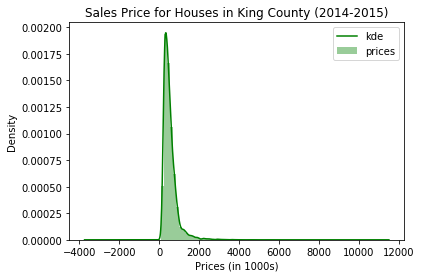

Skewness = 4.023085207745835
kurtosis = 34.53308449607733


In [279]:
# generate histogram for price containing all data
prices = df.price/1000
prices.hist(label = 'prices', bins=50,density=True,color='green',alpha=0.4)
prices.plot.kde(label='kde',color = 'green')
plt.title('Sales Price for Houses in King County (2014-2015)')
plt.xlabel('Prices (in 1000s)')
plt.legend()
plt.show()
print ('Skewness =', skew(df.price))
print ('kurtosis =', kurtosis(df.price))


Observations: high positive skew, extremely high + curtosis, long-tailed distribution.

#### Price - Summary Statistics

In [280]:
# Summary statitics
df.price.describe().apply(lambda x: format(x, 'f'))

count      21597.000000
mean      540296.573506
std       367368.140101
min        78000.000000
25%       322000.000000
50%       450000.000000
75%       645000.000000
max      7700000.000000
Name: price, dtype: object

Observations: ~ 20,000 samples, high standard deviation / variability

Text(0.5, 1.0, 'Distribution of House Prices (in 1000s)')

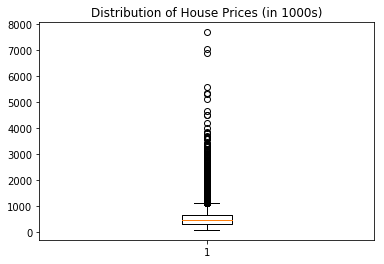

In [281]:
# Spot outliers
plt.boxplot(df.price/1000)
plt.title('Distribution of House Prices (in 1000s)')

Observations: numerous outliers

#### Price - Store in Dataframe after log normalizing

Skewness = 0.43097424174908705
kurtosis = 0.6906107356267639


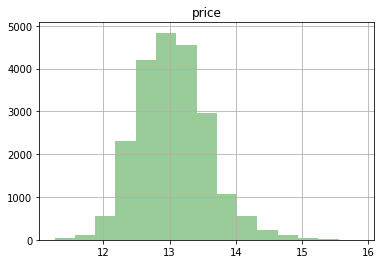

In [282]:
# Take the log of price and store in
price_df = pd.DataFrame(np.log(df.price))
price_df.hist(bins=15,color='green',alpha=0.4)
print ('Skewness =', skew(price_df.price))
print ('kurtosis =', kurtosis(price_df.price))

After log normalizing, the skewness and kurtosis improved.

#### Price - Data Type

In [283]:
price_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21597 entries, 40000362 to 6762700020
Data columns (total 1 columns):
price    21597 non-null float64
dtypes: float64(1)
memory usage: 337.5 KB


Observation: price is a float, which is appropriate due to the log transformation.

#### Features - Store in Dataframe

In [284]:
# create a dataframe for features
features = df.columns.drop(['price'])
features_df = pd.DataFrame(df[features])
features_df.head(2)

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,,,,,,,,,,,,,,,,,,,
40000362,5/6/2014,2,1.00,780,16344,1.0,0.0,0.0,1,5,780,0.0,1942,NaN,98168,47.4739,-122.280,1700,10387
8658300340,5/23/2014,1,0.75,430,5050,1.0,NaN,0.0,2,4,430,0.0,1912,0.0,98014,47.6499,-121.909,1200,7500


###   Features: Descriptive Statistics

#### Data Types 

In [285]:
# obtain column info
features_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21597 entries, 40000362 to 6762700020
Data columns (total 19 columns):
date             21597 non-null object
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(7), int64(10), object(2)
memory usage: 3.3+ MB


Observations:

> There are numerous variables that should be tranformed to categories.

> There are geographical features that would be interesting to display on a map.

> Some variables could be transformed from float to int for efficiency.

### Transform Data Types

Scan features to determine best transformation

In [286]:
# This function scans features dataframe for unique values

# Even though this output is large, scanning all the data is important
# if we are not familiar with its peculiarities.

def unique(features_df):
    for column in features_df:
        print('Name: ' + column)
        print('-'*10)
        na = features_df[column].isna().sum()
        print('NaN values: ' + str(na))
        print('-'*10)
        unique = features_df[column].unique()

        print(unique)

        print('')

In [287]:
unique(features_df)

Name: date
----------
NaN values: 0
----------
['5/6/2014' '5/23/2014' '3/24/2015' '11/5/2014' '5/8/2014' '5/29/2014'
 '4/30/2015' '3/5/2015' '9/15/2014' '7/22/2014' '10/14/2014' '2/19/2015'
 '5/13/2014' '11/29/2014' '4/18/2015' '3/3/2015' '6/16/2014' '5/5/2015'
 '9/19/2014' '12/12/2014' '4/8/2015' '10/29/2014' '1/5/2015' '7/17/2014'
 '5/7/2014' '7/3/2014' '6/10/2014' '6/30/2014' '9/4/2014' '7/1/2014'
 '12/8/2014' '9/2/2014' '3/17/2015' '7/16/2014' '11/26/2014' '8/28/2014'
 '1/14/2015' '9/18/2014' '3/11/2015' '5/12/2014' '10/30/2014' '1/27/2015'
 '6/11/2014' '4/27/2015' '5/19/2014' '2/11/2015' '7/25/2014' '10/17/2014'
 '7/10/2014' '12/5/2014' '7/8/2014' '2/24/2015' '7/15/2014' '1/16/2015'
 '9/24/2014' '10/21/2014' '9/16/2014' '6/4/2014' '1/21/2015' '6/19/2014'
 '10/27/2014' '5/20/2014' '8/4/2014' '3/6/2015' '4/20/2015' '4/22/2015'
 '7/2/2014' '12/26/2014' '12/15/2014' '10/3/2014' '3/26/2015' '5/28/2014'
 '9/5/2014' '10/2/2014' '12/10/2014' '8/26/2014' '10/9/2014' '4/28/2015'
 '11/13/20

> We can see above than none of the categorical variables are identified as such.
> We need to transform the type for several of these variables.

There are problems with various variables.
Address those one variable at a time below 

#### 1. 'sqft_basement' feature

This feature contains unknown values marked with a "?"

In [288]:
# Let's explore how many ? entries are in sqft_basement.
value = '?'
count = 0
for row in features_df['sqft_basement']:
    if row == '?':
        count +=1
print('There are ' + str(count) + ' rows with question marks as unknown values.')
print('This represents ' + str(round(count/len(features_df)*100,2)) + ' percent of the data.')

There are 454 rows with question marks as unknown values.
This represents 2.1 percent of the data.


> There are several ways to transform the unknown ? entries. We could drop these rows or replace them with the median. 

> Personally, I prefer replacing with the median to begin with, which would introduce a neglible amount of noise.

The median value for this basement area is: 0.0
The mean value for this basement area is: 291.851723974838


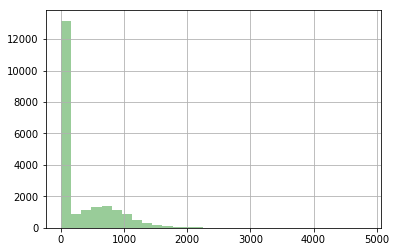

In [289]:
# Because we can't calculate the mean of the dataset with strings, let's create a dummy
# variable to replace the question mark with first.
value = '?'
dummy = 99999
############# . df.loc[:,"Score1"].median()

features_df.loc[:,'sqft_basement'].replace(value, dummy,inplace=True) 

# Now let's convert the type to int
features_df['sqft_basement'] = features_df['sqft_basement'].map(lambda x: float(x))
features_df['sqft_basement'] = features_df['sqft_basement'].map(lambda x: int(x))
features_df['sqft_basement'].unique()[0:15]

# Now let's replace 99999 with the median
features_df.loc[:,'sqft_basement'].replace(dummy,np.nan, inplace=True) 

# Let's plot a histogram 
features_df['sqft_basement'].hist(bins=30,color='green',alpha=0.4)
print('The median value for this basement area is: ' + str(features_df['sqft_basement'].median()))
print('The mean value for this basement area is: ' + str(features_df['sqft_basement'].mean()))


> Since the median for known basement values is zero, we will replace the unknown ? values
> with zero.


In [290]:
# Replace original '?' entries with zeros.
median_sqft = features_df['sqft_basement'].median()
features_df['sqft_basement']= features_df['sqft_basement'].replace(np.nan, median_sqft) 
features_df['sqft_basement'].unique()[0:10]
features_df.sqft_basement = features_df.sqft_basement.astype(int)
print('Done replacing "?" with zeros in sqft_basement')


Done replacing "?" with zeros in sqft_basement


#### 2. 'date' feature:

> Create a column for the year sold based on 'date'. Reformat to integer.
> We will assume that the exact day of the sale is not relevant to our analysis.

In [292]:
features_df['yr_sold'] = features_df['date'].map(lambda x: x.split('/',3))
features_df['month_sold'] = features_df['yr_sold'].map(lambda x: int(x[0]))
features_df['yr_sold'] = features_df['yr_sold'].map(lambda x: int(x[2]))



print('Years of reported sales:')
print(features_df['yr_sold'].unique())
print('Months of reported sales:')
print(features_df['month_sold'].unique())
#features_df.drop('date', axis=1, inplace=True)

Years of reported sales:
[2014 2015]
Months of reported sales:
[ 5  3 11  4  9  7 10  2  6 12  1  8]


> Finding!: This dataset describes houses sold only during 2014 and 2015. 
> We can transform this back to two categories. Perhaps selling in one year or the other
> had an effect on price based on market fluctuations.

Text(0.5, 1.0, 'Number of Homes Sold in 2014, 2015')

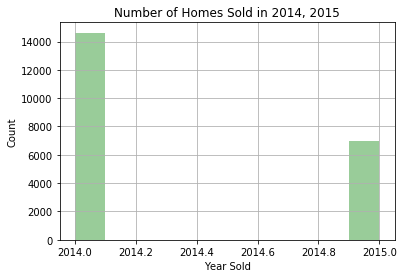

In [302]:
features_df.yr_sold.hist(color='green',alpha=.4)
plt.xlabel('Year Sold')
plt.ylabel('Count')
plt.title('Number of Homes Sold in 2014, 2015')

> Observation: In 2015, home sales decreased to about half of sales in 2014.

Text(0.5, 1.0, 'Monthly Sales in 2014')

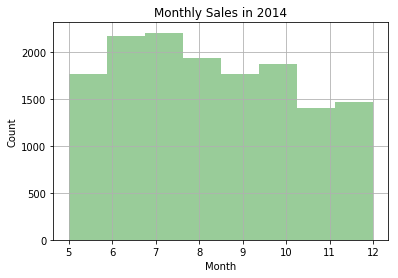

In [312]:
features_df[features_df.yr_sold==2014].month_sold.hist(color='green',alpha=.4, bins=8)
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Monthly Sales in 2014')

Text(0.5, 1.0, 'Monthly Sales in 2015')

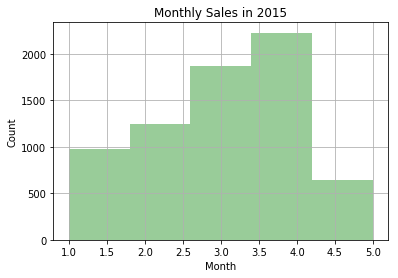

In [317]:
features_df[features_df.yr_sold==2015].month_sold.hist(color='green',alpha=.4,bins=5)
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Monthly Sales in 2015')


### Explore Correlated Variables

Finding correlations between variables is important at this stage to keep
in mind for the later analysis.

In [235]:
# this function returns a dataframe pinpointed correlated variables
# that exceed a correlation threshhold. 
def find_corr_vars(df, threshhold):
    
    threshhold = threshhold
    corr_vars0 = df.corr()
    print('Numbers of variables tested')
    print(len(corr_vars0.columns))
    corr_vars = (corr_vars0 > threshhold)
    length = len(corr_vars0.columns)
    print('Correlations tested:')
    print(corr_vars.size)
    print('Correlations meeting threshhold:')
    print(corr_vars.sum().sum() - length)

    rows=[]
    columns=[]
    for column in range(0,length):
        for row in range(0,length):
            if corr_vars.iloc[row][column] == True:
                rows.append(row)
                columns.append(column)
    corr1 = []
    corr2 = []
    words = list(corr_vars.columns)
    for index in rows:
        word = words[index]
        corr1.append(word)
    for index2 in columns:
        corr2.append(words[index2])

    corr_df = pd.DataFrame(data={'col1': corr1,'col2':corr2})
    print('')

    print('Correlated Variables over threshhold ' + str(threshhold))

    return corr_df[corr_df.col1 != corr_df.col2]

In [238]:
threshhold = 0.5 #set correlation threshhold minimum to filter correlations.
# let's find correlated variables above a certain threshhold
feat_price_df = features_df.join(price_df, how='left')
find_corr_vars(feat_price_df, threshhold).sort_values(by='col1',ascending=False)

Numbers of variables tested
20
Correlations tested:
400
Correlations meeting threshhold:
42

Correlated Variables over threshhold 0.5


,col1,col2
9,yr_built,bathrooms
20,sqft_lot15,sqft_lot
53,sqft_lot,sqft_lot15
17,sqft_living15,sqft_living
31,sqft_living15,grade
38,sqft_living15,sqft_above
60,sqft_living15,price
10,sqft_living15,bathrooms
48,sqft_living,sqft_living15
57,sqft_living,price


> Observation: We see here that sqft_living and correlated variables
> have a marked correlation with price even before processing the data

#### Set Categorical Variables / Reformat

#### 1. 'sqft_basement' feature

In [239]:
# Bin 'sqft_basement' and place in categories (presence or lack of basement)
# First explored this as a continuous variable but distribution was problematic for linear regression

d = {range(0): 'None', range(1,features_df['sqft_basement'].max()): 'Yes'}

features_df['basement'] = features_df['sqft_basement'].apply(lambda x: next((v for k, v in d.items() if x in k), 'None'))



features_df['basement'] = features_df['basement'].astype('category')
#features_df['basement'].hist(color='green',alpha=0.4)
features_df.drop('sqft_basement',axis=1,inplace=True)

#### 2. 'yr_sold' feature

In [240]:
#set 'yr_sold' column as category and delete 'date' column
features_df['yr_sold'] = features_df['yr_sold'].astype('category')


#### 3. 'bathrooms' feature

In [241]:
# bin bathrooms so that 4.5 is mapped to 4 and 4.75 is mapped to 5. 
# Reformat to category.
features_df['bathrooms'] = round(features_df['bathrooms'],0).astype(int)
features_df['bathrooms'] = round(features_df['bathrooms'],0).astype('category')



#### 4. 'waterfront' feature:

In [242]:
# fill NaN values in waterfront and view with zeros.
features_df.waterfront.fillna(0,inplace=True) # 10% of data was missing.
features_df['waterfront'] = features_df['waterfront'].astype(int).astype('category')

#### 5. 'view' feature:

In [243]:
features_df.view.fillna(0,inplace=True)       # less than 1% of data was missing.
features_df['view'] = features_df['view'].astype(int).astype('category')


#### 6. 'bedrooms' feature:

In [244]:
# replace type first to INT then to CATEGORY. No variables needed FLOAT type.
features_df['bedrooms'] = features_df['bedrooms'].astype(int).astype('category')


#### 7. 'floors' feature:

In [245]:
# bin features and set as category
features_df['floors'] = round(features_df['floors'],0).astype(int)

d = {range(0,2):'1', range(2,9):'2plus'}

features_df['floors'] = features_df['floors'].apply(lambda x: next((v for k, v in d.items() if x in k), 0))
features_df['floors'] = features_df['floors'].astype('category')

#### 8. 'conditions' feature

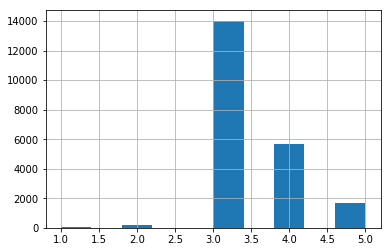

In [247]:
features_df['condition'].hist()

In [101]:
# bin features and set as category

features_df['condition'] = features_df['condition'].astype(int)
d = {range(0,3):'poor', range(3,4):'average',range(4,6):'above_average'}
features_df['condition'] = features_df['condition'].apply(lambda x: next((v for k, v in d.items() if x in k), 0))

features_df['condition'] = features_df['condition'].astype('category')

#### 9. 'zipcode' feature

In [102]:
features_df['zipcode'] = features_df['zipcode'].astype(int).astype('category')

# change a format for basement variable so that all sqft are int

#### 10. 'grade' feature:

In [103]:
features_df['grade'] = features_df['grade'].astype(int).astype('category')

#### 11. 'yr_renovated' feature:

In [104]:
# Create categories for renovations based on how recently they occurred.
# Assumption: More recent renovations drive the price up more.
# There are records of renovations that are more than 30 years old.
# For practicality, we will ignore this "old" renovations and only
# consider a house renovated if it was remodeled within the last 30 years.
features_df.yr_renovated.fillna(0,inplace=True)
features_df['yr_renovated'] = features_df['yr_renovated'].astype(int)
d = {range(0,2000):'no', range(2000, 2015):'recent'}

features_df['renovated'] = features_df['yr_renovated'].apply(lambda x: next((v for k, v in d.items() if x in k), 'no'))
features_df['renovated'] = features_df['renovated'].astype('category')

#drop yr_renovated from features_df
features_df.drop('yr_renovated',axis=1,inplace=True)
print('Most houses have not been remodeled recently.')

Most houses have not been remodeled recently.


#### 12. 'yr_built' feature

In [105]:
# Create a new feature called 'vintage' that will describe how recently
# a house was built.
d = {range(1900,1970):'Before70s',range(1970, 1980): '70s', range(1980, 1990): '80s', range(1990, 2000): '90s', range(2000, 2010): '2000s',range(2010, 2015): '2010s'}

features_df['built'] = features_df['yr_built'].apply(lambda x: next((v for k, v in d.items() if x in k), 0))
print('done')
features_df['built'] = features_df['built'].astype('category')

#drop the year built column, since we categorized it in bins
features_df.drop('yr_built',axis=1,inplace=True)
features_df['built'].head()


done


id
40000362      Before70s
8658300340    Before70s
3028200080    Before70s
3883800011    Before70s
1623049041    Before70s
Name: built, dtype: category
Categories (7, object): [0, 2000s, 2010s, 70s, 80s, 90s, Before70s]

#### 13. 'sqft_lot' feature:

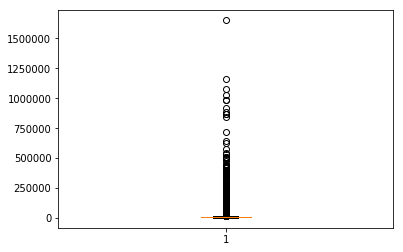

Skewness = 13.071695603822912
kurtosis = 285.4294421924969


In [106]:
plt.boxplot(features_df.sqft_lot)
plt.show()
print ('Skewness =', skew(features_df.sqft_lot))
print ('kurtosis =', kurtosis(features_df.sqft_lot))

Skewness = 0.9624335347705735
kurtosis = 3.328974148585477


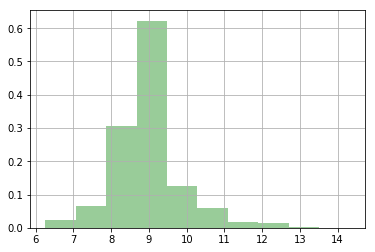

In [107]:
# Create a new feature to deal with lot size
# let's check out the distribution
features_df.sqft_lot = np.log(features_df.sqft_lot)
features_df.sqft_lot.hist(density=True,color='green',alpha=0.4)

print ('Skewness =', skew(features_df.sqft_lot))
print ('kurtosis =', kurtosis(features_df.sqft_lot))




Observations: improved the kurtosis, but it's still a bit high.

#### 14. and 15. 'lat' and 'long' features

> Using the lat lon variables, approximate the distance of houses to downtown seattle.

In [108]:
# calculate a proxy distance from seattle downtown
sea_lat  =  47.6050    # seattle's latitude in decimal degrees
sea_long = -122.3344   # seattle's longitude ''  ''      ''
lat_conv = 69.09       # approximate factor to convert decimal degrees to distance in miles
long_conv = 46.54      # gotten from http://www.csgnetwork.com/degreelenllavcalc.html

# go through latitude and longitude data and calculate component distance 
# from seattle.
features_df['sea_dist_lat'] = abs(sea_lat - features_df['lat'])*lat_conv
features_df['sea_dist_long'] = abs(sea_long - features_df['long'])*long_conv

# Using the components, calculate approximate distance using Pythagorean theorem.
features_df['approx_dist'] = np.sqrt((features_df['sea_dist_lat'])**2 + (features_df['sea_dist_long'])**2)



#### QC distance approximation

> Calculating distances using this method is a crude approximation.

> It is necessary to check whether the results make sense geographically.

> Calculations were validated by mapping the data and researching distances manually.

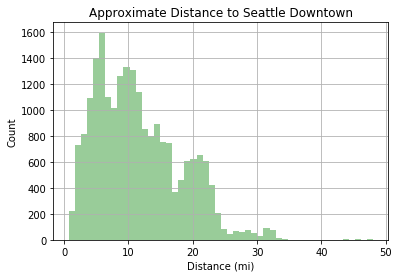

In [109]:
# First QC tool: generate a histogram of distances from the city center
# to the various houses. 
features_df.approx_dist.hist(bins=50,color='green',alpha=.4)
plt.xlabel('Distance (mi)')
plt.ylabel('Count')
plt.title('Approximate Distance to Seattle Downtown')
plt.show()

In [110]:
# Based on this histogram, when we plot a heatmap of locations, most
# houses should be located within a 10-15 radius of the city center.

#### Plot heatmap of location values

In [111]:
# Use the folium utility to create a house density map.
# we used the original lat and long values to determine whether most
# houses are located very near Seattle.

def map_values(center_lat, center_long, df):
   
    m = folium.Map([center_lat,center_long], zoom_start=10)
    folium.Marker([center_lat,center_long]).add_to(m)

    locations = df[['lat', 'long']]
    locationlist = locations.values.tolist()
    m.add_children(plugins.HeatMap(locationlist, radius=20, min_opacity=0.25))
    return m

In [112]:
map_values(sea_lat,sea_long,df)

In [113]:
# Yes, after validating our data using this and outside map
# we can include this distance approximation in our analysis.

In [114]:
# reformat / drop columns 
features_df.drop('sea_dist_long',axis=1,inplace=True)
features_df.drop('sea_dist_lat',axis=1,inplace=True)
features_df.drop('lat',axis=1,inplace=True)
features_df.drop('long',axis=1,inplace=True)
features_df.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,zipcode,sqft_living15,sqft_lot15,yr_sold,basement,renovated,built,approx_dist
id,,,,,,,,,,,,,,,,,,
40000362,2,1,780,9.701616,1,0,0,poor,5,780,98168,1700,10387,2014,None,no,Before70s,9.404882
8658300340,1,1,430,8.527144,1,0,0,poor,4,430,98014,1200,7500,2014,None,no,Before70s,20.039678
3028200080,2,1,730,9.207837,1,0,0,poor,5,730,98168,860,9000,2015,None,no,Before70s,8.628347
3883800011,3,1,860,9.252058,1,0,0,good,6,860,98146,1140,11250,2014,None,no,Before70s,7.350688
1623049041,2,1,520,10.013865,1,0,0,poor,5,520,98168,1572,10570,2014,None,no,Before70s,8.825987


#### Check data info again


In [115]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21597 entries, 40000362 to 6762700020
Data columns (total 18 columns):
bedrooms         21597 non-null category
bathrooms        21597 non-null category
sqft_living      21597 non-null int64
sqft_lot         21597 non-null float64
floors           21597 non-null category
waterfront       21597 non-null category
view             21597 non-null category
condition        21597 non-null category
grade            21597 non-null category
sqft_above       21597 non-null int64
zipcode          21597 non-null category
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
yr_sold          21597 non-null category
basement         21597 non-null category
renovated        21597 non-null category
built            21597 non-null category
approx_dist      21597 non-null float64
dtypes: category(12), float64(2), int64(4)
memory usage: 2.0 MB


#### Create heatmaps and correlation matrix

In [116]:
features_df.corr()>.7

,sqft_living,sqft_lot,sqft_above,sqft_living15,sqft_lot15,approx_dist
sqft_living,True,False,True,True,False,False
sqft_lot,False,True,False,False,False,False
sqft_above,True,False,True,True,False,False
sqft_living15,True,False,True,True,False,False
sqft_lot15,False,False,False,False,True,False
approx_dist,False,False,False,False,False,True


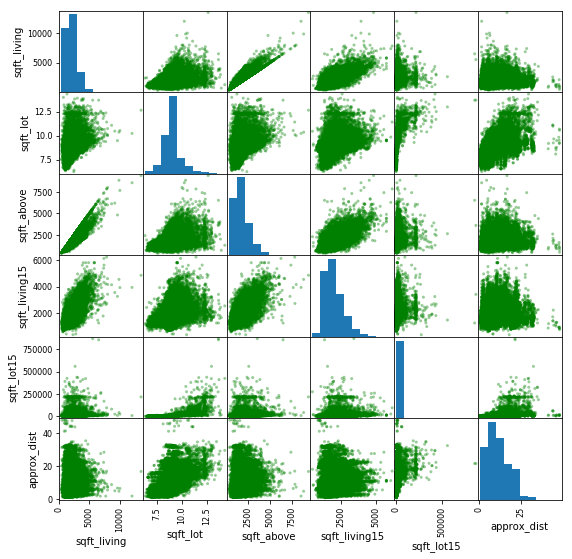

In [117]:
pd.plotting.scatter_matrix(features_df,figsize  = [9, 9], color='green',alpha=0.4)
plt.show()


####  16 , 17, 18 : 'sqft_living' , 'sqft_above' , 'sqft_living15' features

>  These variables are correlated over 70% of the time.
>  Let's choose only one for our model. The best correlated with price!

In [118]:
# calculate correlations with target values for correlated variables
# to choose the best for our model
corr_columns = ['sqft_living','sqft_living15','sqft_above']
df_corr = price_df.join(features_df[corr_columns],how='left')
df_corr.corr()

,price,sqft_living,sqft_living15,sqft_above
price,1.000000,0.695067,0.620297,0.601720
sqft_living,0.695067,1.000000,0.756843,0.876282
sqft_living15,0.620297,0.756843,1.000000,0.731540
sqft_above,0.601720,0.876282,0.731540,1.000000


In [119]:
# based on these results, we will nix: sqft_living15 & sqft_abovve

In [120]:
features_df.drop('sqft_living15',axis=1,inplace=True)
features_df.drop('sqft_above',axis=1,inplace=True)

In [121]:
# transform to float
features_df['sqft_living'] = features_df['sqft_living'].astype(float)

#### 19 sqft_lot15 and sqft_lot

In [122]:
features_df.drop('sqft_lot15',axis=1,inplace=True)

In [123]:
# Remaining correlations
features_df.corr()

,sqft_living,sqft_lot,approx_dist
sqft_living,1.000000,0.344670,0.076684
sqft_lot,0.344670,1.000000,0.419175
approx_dist,0.076684,0.419175,1.000000


In [124]:
# Looks good, no remaining strong correlations!
# for now we will keep these

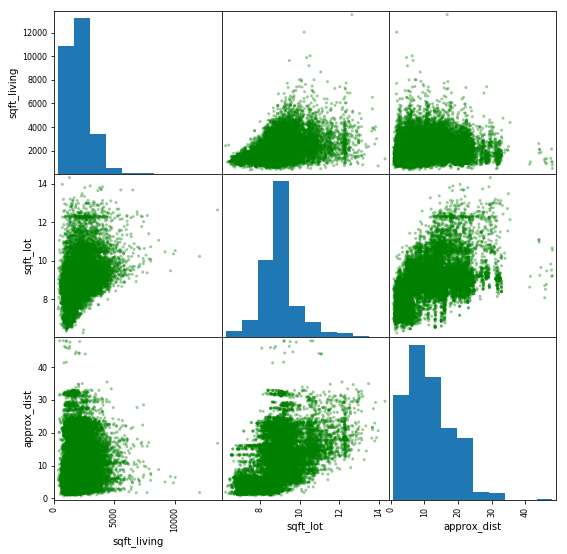

In [125]:
pd.plotting.scatter_matrix(features_df,figsize  = [9, 9], color='green',alpha=0.4)
plt.show()

#### Dummy variables


In [126]:
'''not working
cat_vars = ['bedrooms','bathrooms','floors','waterfront','view','condition','grade','zipcode','yr_sold','renovated','vintage']
dummy_values = []
for var in cat_vars:
    dummy_values.append(pd.get_dummies(features_df[var],prefix=var[0:3]))'''


"not working\ncat_vars = ['bedrooms','bathrooms','floors','waterfront','view','condition','grade','zipcode','yr_sold','renovated','vintage']\ndummy_values = []\nfor var in cat_vars:\n    dummy_values.append(pd.get_dummies(features_df[var],prefix=var[0:3]))"

In [127]:
#features_df = features_df.drop(cat_vars, axis=1)

bed= pd.get_dummies(features_df['bedrooms'], prefix="bed")
bath= pd.get_dummies(features_df['bathrooms'], prefix="bath")
floor= pd.get_dummies(features_df['floors'], prefix="flo")
water= pd.get_dummies(features_df['waterfront'], prefix="water")
view= pd.get_dummies(features_df['view'], prefix="view")
cond = pd.get_dummies(features_df['condition'], prefix="cond")
grade= pd.get_dummies(features_df['grade'], prefix="grade")
zipc= pd.get_dummies(features_df['zipcode'], prefix="zip")
sold= pd.get_dummies(features_df['yr_sold'], prefix="sold")
renov = pd.get_dummies(features_df['renovated'], prefix="renov")
built = pd.get_dummies(features_df['built'], prefix="built")
base = pd.get_dummies(features_df['basement'], prefix="base")

In [128]:

features_df = pd.concat([features_df,bed, bath,floor,water,view,cond,sold,renov,grade,built,base,zipc],axis=1) #drop bed bath drop grade as test
features_df.shape

# drop categorical variables written before hot encoding
cat_vars = ['bedrooms','bathrooms','floors','waterfront','view','condition','grade','zipcode','yr_sold','renovated','built','basement']
features_df.drop(cat_vars,axis=1,inplace=True)

#### Normalize values

In [129]:
# normalize continuous features in dataframe
column ='sqft_living'
features_df[column] = np.log(features_df[column])
features_df[column] = (features_df[column] - features_df[column].mean()) / features_df[column].std()

column ='approx_dist'
features_df[column] = np.log(features_df[column])
features_df[column] = (features_df[column] - features_df[column].mean()) / features_df[column].std()

column ='sqft_lot'
features_df[column] = (features_df[column] - features_df[column].mean()) / features_df[column].std()


In [130]:
features_df.head()

,sqft_living,sqft_lot,approx_dist,bed_1,bed_2,bed_3,bed_4,bed_5,bed_6,bed_7,...,zip_98146,zip_98148,zip_98155,zip_98166,zip_98168,zip_98177,zip_98178,zip_98188,zip_98198,zip_98199
id,,,,,,,,,,,,,,,,,,,,,
40000362,-2.101474,0.789080,-0.018108,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
8658300340,-3.505344,-0.512884,1.133406,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3028200080,-2.257653,0.241700,-0.149285,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3883800011,-1.871299,0.290721,-0.393229,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1623049041,-3.057329,1.135224,-0.114811,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


#### Check Linearity Assumptions

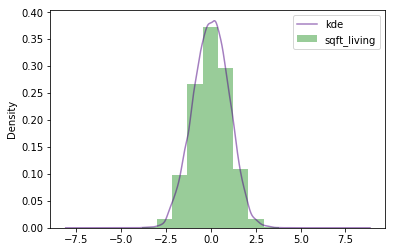

Skewness = -0.027360069339444994
kurtosis = -0.07929775335686351


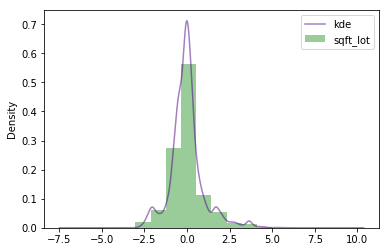

Skewness = 0.9624335347705764
kurtosis = 3.328974148585484


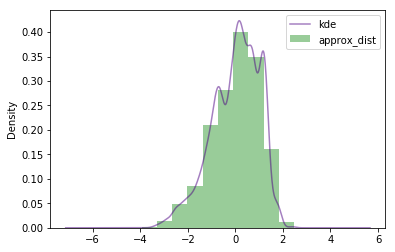

Skewness = -0.598212714437572
kurtosis = 0.004374917825920477


In [131]:
# check distributions for the 3 continuous variables

for column in features_df.iloc[:,0:3]:
    features_df[column].plot.hist(normed=True,color='green',alpha=0.4,label=column, range=(features_df[column].min(),features_df[column].max()))
    features_df[column].plot.kde(label='kde',color='indigo',alpha=0.5)
    plt.legend()
    plt.show()
    print ('Skewness =', skew(features_df[column]))
    print ('kurtosis =', kurtosis(features_df[column]))
    
    
    
    

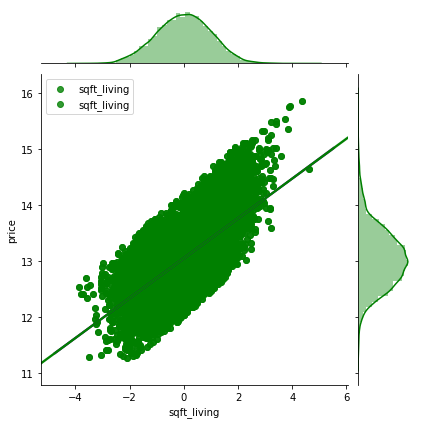

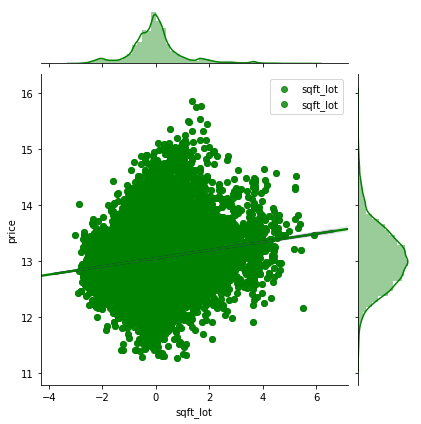

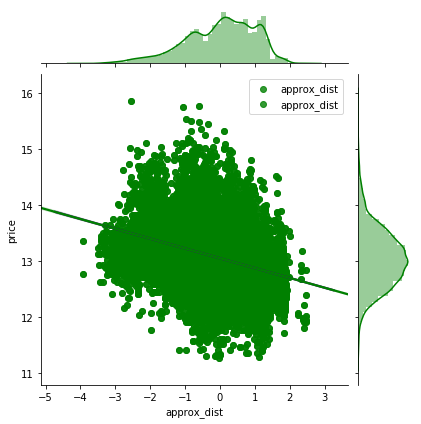

In [132]:
temp_price = price_df['price']
for column in features_df.iloc[:,0:3]:
    sns.jointplot(x=column, y=temp_price,
                  data=features_df, 
                  kind='reg', 
                  color = 'green',
                  label=column,
                  joint_kws={'line_kws':{'color':'indigo'}})
    sns.regplot(features_df[column], temp_price, label=column, color='green')
    plt.legend()
    plt.show()

#### Run first model and identify opportunities for improvement.

### Run Linear Regression for Feature Selection

In [133]:
# returns a dataframe with regression information per variable.
# df is the dataframe containing features
# price_df is the dataframe containing the target
# pvalue is the maximum p-value accepted.

def run_single_linreg(df, price_df,pvalue):
    col_names = df.columns
    data_df = price_df.join(df,how='left')

    results = [['ind_var', 'r_squared', 'intercept', 'slope', 'p-value' ]]
    for val in (col_names):
        f = 'price~' + val
        model = smf.ols(formula=f, data=data_df).fit()
        X_new = pd.DataFrame({val: [data_df[val].min(), data_df[val].max()]});
        preds = model.predict(X_new)
        results.append([val, model.rsquared, model.params[0], model.params[1], model.pvalues[1] ])
    results_df = pd.DataFrame(results, columns=results[0])
    results_df.drop(0,inplace=True)
    results_df.set_index('ind_var',inplace=True)
    results_df = results_df[results_df['p-value']<=pvalue]
    return results_df
    

In [134]:
single_linreg_1 = run_single_linreg(features_df, price_df,0.05)
single_linreg_1.sort_values('r_squared',ascending=False).head()

,r_squared,intercept,slope,p-value
ind_var,,,,
sqft_living,0.456005,13.0458,0.357064,0
bath_1,0.12195,13.1313,-0.476404,0
grade_10,0.113255,13.0017,0.801829,0
grade_7,0.111116,13.1924,-0.357763,0
approx_dist,0.109001,13.0435,-0.175161,0


In [135]:
# features selected as 1st pass
predictors1 = single_linreg_1.index

### Run Multiple Linear Regression Model #1

In [136]:
# This function takes features (predictors) inside a dataframe (df)
# and creates the best fit to explain the 'price' (price_df)

def run_mult_linreg(df, price_df, predictors):
    y = price_df.price
    X = df[predictors]
    n_predictors = len(predictors)
    linreg = LinearRegression()
    r_list = []
    adj_r_list = []
    list_n = list(range(n_predictors//2,n_predictors))  #n predictors calculated above
    for n in list_n: 
        select_n = RFE(linreg, n_features_to_select = n)
        select_n = select_n.fit(X, np.ravel(y))
        selected_columns = X.columns[select_n.support_ ]
        linreg.fit(X[selected_columns],y)
        yhat = linreg.predict(X[selected_columns])
        SS_Residual = np.sum((y-yhat)**2)
        SS_Total = np.sum((y-np.mean(y))**2)
        r_squared = 1 - (float(SS_Residual))/SS_Total
        print(r_squared)
        adjusted_r_squared = 1 - (1-r_squared)*(len(y)-1)/(len(y)-X.shape[1]-1)
    r_list.append(r_squared)
    adj_r_list.append(adjusted_r_squared)
    print('r-squared: ' + str(r_list))
    print('adj r-squared: ' + str(adj_r_list))
    return linreg

In [137]:
# Run the first linear regression and print r-squared values
mult_linreg1 = run_mult_linreg(features_df,price_df,predictors1)

0.795386819675387
0.8081150932557205
0.8126738730555286
0.8148767517382551
0.8183096977413604
0.8194375185161183
0.8213846697294507
0.8163605731184743
0.8226182886968828
0.8320179805040446
0.842658091842934
0.8464665650807623
0.8475642528520668
0.8479037679509889
0.8483468997983
0.8494252690078037
0.8506591979299122
0.8514285171989978
0.8523318706926464
0.8402174976921414
0.8546251828208348
0.8549835491974308
0.8554157304126149
0.8557641248337221
0.8557767607038108
0.8680555619716223
0.8687639447765998
0.8694894521835363
0.8698304806947212
0.8698849965757195
0.8699344913757272
0.8699578527847537
0.8702700234142843
0.8703659565039283
0.8704507483131063
0.8707831175151157
0.8711496268895764
0.8714699934624114
0.8716870306491685
0.8718830052594008
0.8721030900563733
0.8813704676571343
0.8814500267308719
0.8699060919300374
0.8816254166650639
0.8816273780772239
0.8816301307916314
0.8816304232807677
0.880809648156012
0.8818579988640702
0.8819915428547643
0.8819916097332072
0.8819928753007419

#### Cross Validation Scores

In [138]:
def run_cross_validation(linreg,df, price_df, predictors,cv_number):
    y = price_df.price
    X = df[predictors]
    n_predictors = len(list(predictors))
    select_n = RFE(linreg, n_features_to_select = n_predictors)
    select = select_n.fit(X, np.ravel(y))
    selected_columns = X.columns[select_n.support_]

    cv_10_results = cross_val_score(linreg, X[selected_columns], y, cv=10, scoring="neg_mean_squared_error")
    print(str(n_predictors) + ' predictors used.')
    print(cv_10_results)

In [139]:
run_cross_validation(mult_linreg1,features_df,price_df,predictors1,10)

116 predictors used.
[-1.12871884e-01 -3.44833733e+18 -3.02083589e-02 -2.71962736e-02
 -2.68286801e-02 -2.73435182e-02 -2.62425812e-02 -2.81183348e-02
 -3.27784128e-02 -4.14808774e+16]


In [140]:
# Large cross-validation values indicate multicollinearity issues!

In [141]:
def run_ols_model(df, price_df,predictors):
    data_df = price_df.join(df,how='left')
    outcome = 'price'

    data_df.info()
    predictors_list = '+'.join(list(predictors))

    formula = outcome + "~" + predictors_list
    model = ols(formula=formula, data=data_df).fit()
    return(model)

In [142]:
ols_model_1 = run_ols_model(features_df,price_df,predictors1)
ols_model_1.summary()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21953 entries, 1000102 to 9900000190
Columns: 130 entries, price to zip_98199
dtypes: float64(4), uint8(126)
memory usage: 3.5 MB


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.880
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     1468.
Date:                Fri, 07 Jun 2019   Prob (F-statistic):               0.00
Time:                        19:21:26   Log-Likelihood:                 6086.3
No. Observations:               21953   AIC:                        -1.195e+04
Df Residuals:                   21843   BIC:                        -1.107e+04
Df Model:                         109                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           3.5755      0.054     66.810      0.000       3.471       3.680
sqft_living         0.1973      0.003     68.248      0.000       0.192       0.203
sqft_lot            0.0734      0.002     37.747      0.000       0.070       0.077
approx_dist        -0.1788      0.006    -28.953      0.000      -0.191      -0.167
bed_1               0.1417      0.084      1.691      0.091      -0.023       0.306
bed_2               0.1198      0.083      1.448      0.148      -0.042       0.282
bed_3               0.1014      0.083      1.228      0.219      -0.060       0.263
bed_4               0.1034      0.083      1.253      0.210      -0.058       0.265
bed_5               0.0753      0.083      0.911      0.362      -0.087       0.237
bed_6               0.0463      0.083      0.557      0.578      -0.117       0.209
bed_7              -0.0489      0.088     -0.556      0.578      -0.221       0.123
bed_8              -0.0165      0.097     -0.170      0.865      -0.207       0.174
bed_9              -0.0781      0.113     -0.692      0.489      -0.299       0.143
bath_0              0.2202      0.085      2.598      0.009       0.054       0.386
bath_1              0.4105      0.023     17.788      0.000       0.365       0.456
bath_2              0.4223      0.023     18.628      0.000       0.378       0.467
bath_3              0.4487      0.023     19.781      0.000       0.404       0.493
bath_4              0.4648      0.023     20.448      0.000       0.420       0.509
bath_5              0.5399      0.031     17.606      0.000       0.480       0.600
bath_6              0.5470      0.041     13.483      0.000       0.467       0.626
bath_7              0.1676      0.119      1.414      0.157      -0.065       0.400
bath_8              0.3545      0.090      3.930      0.000       0.178       0.531
flo_1               1.7856      0.027     66.533      0.000       1.733       1.838
flo_2plus           1.7899      0.027     66.776      0.000       1.737       1.842
water_0             1.5800      0.028     56.375      0.000       1.525       1.635
water_1             1.9955      0.029     69.588      0.000       1.939       2.052
view_0              0.5618      0.012     48.750      0.000       0.539       0.584
view_1              0.6907      0.014     49.597      0.000       0.663       0.718
view_2              0.6794      0.012     55.312      0.000       0.655       0.703
view_3              0.7515      0.013     57.572      0.000       0.726       0.777
view_4              0.8921      0.015     60.127      0.000       0.863       0.921
cond_good           1.8768      0.027     68.747      0.000       1.823       1.930
cond_poor           1.6988      0.028     61.288      0.000       1.644       1.753
renov_no            1.7397      0.027     64.228      0.000

### ANALYSIS

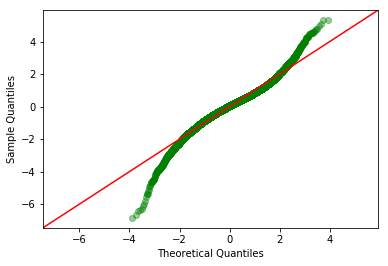

In [143]:
fig = sm.graphics.qqplot(ols_model_1.resid, dist=stats.norm, line=('45'), fit=True,color='green',alpha=.4)



In [144]:
# Even though the P-value was acceptable, the qq plot shows that there is
# is a long tailed distribution where there are more extreme values than
# expected for a normal distribution.
# We need to check for these extreme values.

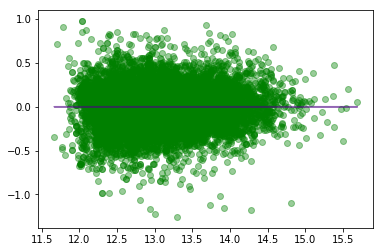

In [145]:
data_df1 = price_df.join(features_df,how='left')
plt.scatter(ols_model_1.predict(data_df1), ols_model_1.resid,color='green',alpha=.4)
plt.plot(ols_model_1.predict(data_df1), [0 for i in range(len(data_df1))],color='indigo',alpha=.6)
                                                      
                                                      

> Improve SQFT_BASEMENT VARIABLE

> NOT convinced about SQFT LOT's regression

> Check the linearity assumptions

> There are still correlated variables!

## ITERATION 2

> Issue 1: multicollinearity

> Issue 2: Outliers

> Issue 3: long-tailed distributions 

### Explore Variable Relationships

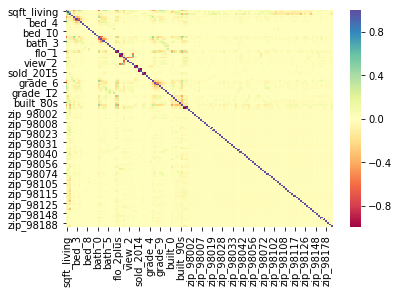

In [146]:
import seaborn as sns
sns.heatmap(features_df.corr(), center=0, cmap='Spectral');

Observations: there are correlated variables still in the features df

Let's use original dataset to explore correlations.

#### Bedrooms vs. Living Area

Text(0, 0.5, 'Living Area (sqft)')

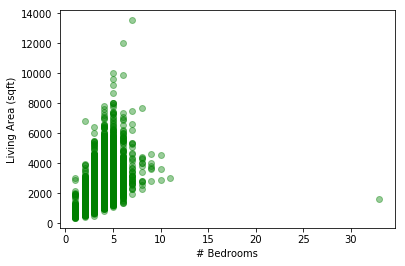

In [147]:
plt.scatter(df.bedrooms,df.sqft_living,color='green',alpha=0.4)
plt.xlabel('# Bedrooms')
plt.ylabel('Living Area (sqft)')

This datapoint (33 bedrooms) looks like a typing error. Maybe they meant 3 bedrooms

In [148]:
# let's find out this datapoint in the dataframe
df.loc[df['bedrooms'] == 33]


,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,,,,,,,,,,,,,,,,,,,,
2402100895,6/25/2014,640000.0,33,1.75,1620,6000,1.0,0.0,0.0,5,7,1040,580.0,1947,0.0,98103,47.6878,-122.331,1330,4700


It is clear this was a typo, a house with 1620 sqft cannot have 33 bedrooms

In [149]:
# Let's replace this value with a 3
df.loc[2402100895,'bedrooms'] = 3

Text(0, 0.5, 'Living Area (sqft)')

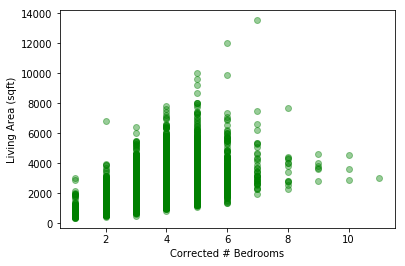

In [150]:
plt.scatter(df.bedrooms,df.sqft_living, color='green',alpha=0.4)
plt.xlabel('Corrected # Bedrooms')
plt.ylabel('Living Area (sqft)')

#### Bathrooms vs. Living Area

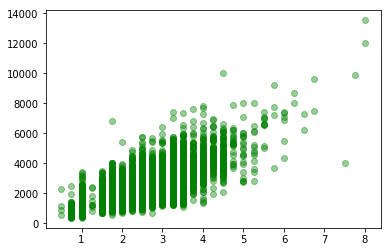

In [151]:
plt.scatter(df.bathrooms,df.sqft_living,color='green',alpha=0.4)

In [152]:
df.loc[df['bathrooms'] == 8]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,,,,,,,,,,,,,,,,,,,,
1225069038,5/5/2014,2280000.0,7,8.0,13540,307752,3.0,0.0,4.0,3,12,9410,4130.0,1999,0.0,98053,47.6675,-121.986,4850,217800
6762700020,10/13/2014,7700000.0,6,8.0,12050,27600,2.5,0.0,3.0,4,13,8570,3480.0,1910,1987.0,98102,47.6298,-122.323,3940,8800


These are resonable although 8 bathrooms in 4000 sqft seems cramped.

In [153]:
#Bathrooms and # of bedrooms are correlated with Living area.
log_area = np.log(df.sqft_living)

In [154]:
living_df = pd.DataFrame({'sqft_living': log_area, 
                         'bed':df.bedrooms.astype(int), 
                         'bath': df.bathrooms.astype(int),
                         'floors':df.floors.astype(int),
                         'sqft_lot': df.sqft_lot})
living_df.corr()>.4


,sqft_living,bed,bath,floors,sqft_lot
sqft_living,True,True,True,False,False
bed,True,True,True,False,False
bath,True,True,True,True,False
floors,False,False,True,True,False
sqft_lot,False,False,False,False,True


### Remove Correlated Variables/Dummies

In [155]:
# remove bed and bath and grade from features_df
drop_list=[]
feat_list = features_df.columns
for name in feat_list:
    if name.startswith('bed') or name.startswith('bath') or name.startswith('grade'):
        drop_list.append(name)

features_df.drop(drop_list,axis=1,inplace=True)

#### Living Area Vs Lot Area

In [156]:
log_area = np.log(features_df.sqft_living)

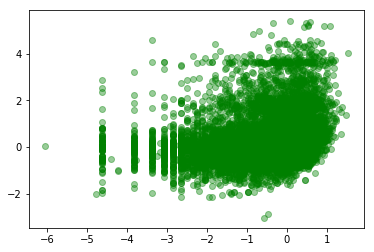

In [157]:
plt.scatter(log_area,features_df.sqft_lot,color ='green',alpha=0.4)

In [158]:
area = pd.DataFrame({'area': log_area, 'lot':features_df.sqft_lot})
area.corr()

,area,lot
area,1.000000,0.222706
lot,0.222706,1.000000


In [161]:
linreg2 = run_single_linreg(features_df, price_df,0.05)
predictors2 = linreg2.index
linreg2.head()

,r_squared,intercept,slope,p-value
ind_var,,,,
sqft_living,0.456005,13.0458,0.357064,0
sqft_lot,0.0187965,13.0434,0.0728255,1.39574e-92
approx_dist,0.109001,13.0435,-0.175161,0
flo_1,0.105719,13.2145,-0.344075,0
flo_2plus,0.105719,12.8705,0.344075,0


In [162]:
predictors2 = list(linreg2.index)

In [163]:
mult_linreg2 = run_mult_linreg(features_df, price_df, predictors2)

0.7780085390991609
0.7799700999688404
0.7848570633834875
0.7915108918696483
0.7985432010170951
0.8059829579261166
0.8096297498345153
0.8119293367164646
0.8153390004213706
0.8180416245231131
0.8195438394493303
0.822262198919499
0.8227450925844807
0.8245155100939036
0.8252251044598335
0.8261717170362208
0.8271163197531077
0.8278076184432053
0.8288479930498058
0.8293321995142113
0.8296317050501345
0.8301044307208165
0.8304060465770795
0.8303272363404713
0.847762035984773
0.8483207445914298
0.8488656822990608
0.8491046769313513
0.8494532844819841
0.8496110183899127
0.8502655659411477
0.8606483412851901
0.860970373890768
0.8625752795870903
0.86269582718221
0.8627376203370738
0.8628703495620127
0.862879797886447
0.8634108243128413
0.8635903365008997
0.8635967661292376
0.8636041541386047
0.8636133891176692
0.8636362729308913
r-squared: [0.8636362729308913]
adj r-squared: [0.8630783406274656]


In [164]:
run_cross_validation(mult_linreg2,features_df,price_df,predictors2,10)

88 predictors used.
[-0.0956049  -0.03384387 -0.03086615 -0.03151758 -0.03262103 -0.03265758
 -0.03019397 -0.03039234 -0.03412656 -0.12946078]


In [165]:
ols_model_2 = run_ols_model(features_df,price_df,predictors2)
ols_model_2.summary()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21953 entries, 1000102 to 9900000190
Data columns (total 98 columns):
price              21953 non-null float64
sqft_living        21953 non-null float64
sqft_lot           21953 non-null float64
approx_dist        21953 non-null float64
flo_1              21953 non-null uint8
flo_2plus          21953 non-null uint8
water_0            21953 non-null uint8
water_1            21953 non-null uint8
view_0             21953 non-null uint8
view_1             21953 non-null uint8
view_2             21953 non-null uint8
view_3             21953 non-null uint8
view_4             21953 non-null uint8
cond_good          21953 non-null uint8
cond_poor          21953 non-null uint8
sold_2014          21953 non-null uint8
sold_2015          21953 non-null uint8
renov_no           21953 non-null uint8
renov_recent       21953 non-null uint8
built_0            21953 non-null uint8
built_2000s        21953 non-null uint8
built_2010s        21953 non-nul

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.861
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     1659.
Date:                Fri, 07 Jun 2019   Prob (F-statistic):               0.00
Time:                        19:25:11   Log-Likelihood:                 4523.7
No. Observations:               21953   AIC:                            -8881.
Df Residuals:                   21870   BIC:                            -8218.
Df Model:                          82                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           3.6132      0.004    946.703      0.000       3.606       3.621
sqft_living         0.2611      0.002    125.277      0.000       0.257       0.265
sqft_lot            0.0889      0.002     43.671      0.000       0.085       0.093
approx_dist        -0.1957      0.007    -29.600      0.000      -0.209      -0.183
flo_1               1.8064      0.003    649.905      0.000       1.801       1.812
flo_2plus           1.8068      0.003    675.254      0.000       1.802       1.812
water_0             1.5978      0.009    176.618      0.000       1.580       1.615
water_1             2.0155      0.011    179.427      0.000       1.993       2.037
view_0              0.5281      0.005    114.538      0.000       0.519       0.537
view_1              0.6810      0.010     71.171      0.000       0.662       0.700
view_2              0.6834      0.007    104.655      0.000       0.671       0.696
view_3              0.7763      0.008     97.323      0.000       0.761       0.792
view_4              0.9444      0.011     86.005      0.000       0.923       0.966
cond_good           1.9039      0.006    311.635      0.000       1.892       1.916
cond_poor           1.7094      0.008    216.816      0.000       1.694       1.725
renov_no            1.7443      0.005    355.121      0.000       1.735       1.754
renov_recent        1.8689      0.006    298.016      0.000       1.857       1.881
built_0             0.0840      0.032      2.587      0.010       0.020       0.148
built_2000s         0.0624      0.006     10.605      0.000       0.051       0.074
built_2010s         0.1412      0.008     18.652      0.000       0.126       0.156
built_70s          -0.0402      0.006     -6.716      0.000      -0.052      -0.028
built_90s           0.0326      0.006      5.409      0.000       0.021       0.044
built_Before70s    -0.0348      0.005     -6.761      0.000      -0.045      -0.025
base_None           1.8329      0.003    711.775      0.000       1.828       1.838
base_Yes            1.7803      0.003    685.383      0.000       1.775       1.785
zip_98001          -0.3042      0.013    -23.853      0.000      -0.329      -0.279
zip_98002          -0.2996      0.016    -18.724      0.000      -0.331      -0.268
zip_98003          -0.2490      0.014    -18.065      0.000      -0.276      -0.222
zip_98004           0.6098      0.014     44.754      0.000       0.583       0.636
zip_98005           0.2893      0.016     17.552      0.000       0.257       0.322
zip_98006           0.2528      0.010     24.619      0.000       0.233       0.273
zip_98007           0.2099      0.017     12.135      0.000       0.176       0.244
zip_98008           0.2270      0.013     17.680      0.000       0.202       0.252
zip_98010          -0.0296      0.021     -1.380      0.168

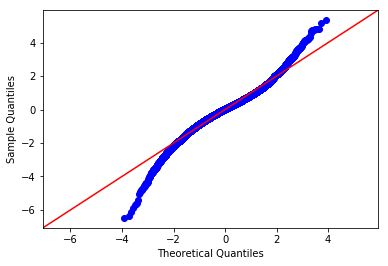

In [166]:
fig = sm.graphics.qqplot(ols_model_2.resid, dist=stats.norm, line='45', fit=True)

## Correlation Threshhold = 0.4

In [168]:
# this function returns a dataframe with correlated variables 
# arguments are: min correlation tested, and a dataframe of variables
def find_corr_vars(threshhold, df):
    
    threshhold = threshhold
    corr_vars0 = df.corr()
    print('Numbers of variables tested')
    print(len(corr_vars0.columns))
    corr_vars = (corr_vars0 > threshhold)
    length = len(corr_vars0.columns)
    print('Correlations tested:')
    print(corr_vars.size)
    print('Correlations meeting threshhold:')
    print(corr_vars.sum().sum() - length)

    rows=[]
    columns=[]
    for column in range(0,length):
        for row in range(0,length):
            if corr_vars.iloc[row][column] == True:
                rows.append(row)
                columns.append(column)
    corr1 = []
    corr2 = []
    words = list(corr_vars.columns)
    for index in rows:
        word = words[index]
        corr1.append(word)
    for index2 in columns:
        corr2.append(words[index2])

    corr_df = pd.DataFrame(data={'col1': corr1,'col2':corr2})
    print('')

    print('Correlated Variables over threshhold ' + str(threshhold))

    return corr_df[corr_df.col1 != corr_df.col2]

In [174]:
find_corr_vars(0.4,features_df)

Numbers of variables tested
97
Correlations tested:
9409
Correlations meeting threshhold:
6

Correlated Variables over threshhold 0.4


,col1,col2
2,approx_dist,sqft_lot
3,sqft_lot,approx_dist
6,built_Before70s,flo_1
10,view_4,water_1
15,water_1,view_4
29,flo_1,built_Before70s


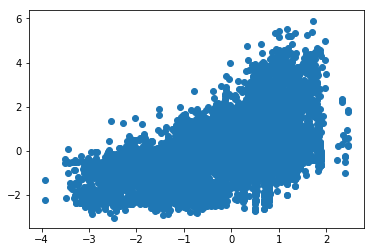

In [175]:
plt.scatter(features_df.approx_dist,features_df.sqft_lot)

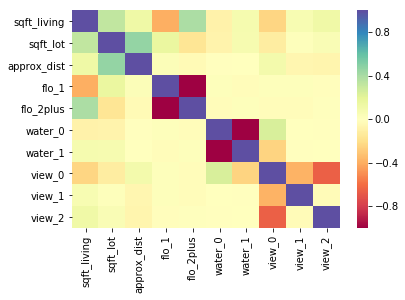

In [176]:
sns.heatmap(features_df.corr().iloc[0:10,0:10], center=0, cmap='Spectral');



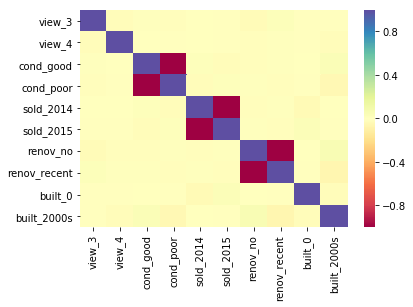

In [178]:
sns.heatmap(features_df.corr().iloc[10:20,10:20], center=0, cmap='Spectral');
#sns.heatmap(corr_test_df.corr(), center=0, cmap='Spectral');



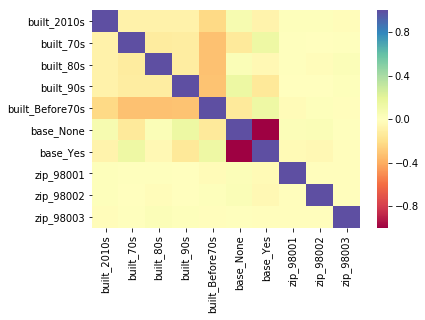

In [179]:
sns.heatmap(features_df.corr().iloc[20:30,20:30], center=0, cmap='Spectral');

Based on these findings, will drop flo_1,flo_2,sqft_lot from analysis.


In [180]:

features_df.drop('flo_1',axis=1,inplace=True)
features_df.drop('sqft_lot',axis=1,inplace=True)
features_df.drop('sold_2014',axis=1,inplace=True)
features_df.drop('view_0', axis=1,inplace=True)
features_df.drop('cond_poor',axis=1,inplace=True)
features_df.drop('water_0',axis=1,inplace=True) 
features_df.drop('renov_no',axis=1,inplace=True)
features_df.drop('base_None',axis=1,inplace=True)

#dropped because - correlated with water 1

In [181]:
find_corr_vars(0.5,features_df)

Numbers of variables tested
89
Correlations tested:
7921
Correlations meeting threshhold:
2

Correlated Variables over threshhold 0.5


,col1,col2
4,view_4,water_1
8,water_1,view_4


In [182]:
linreg3 = run_single_linreg(features_df, price_df,0.05)
predictors3 = list(linreg3.index)
linreg3.head()

,r_squared,intercept,slope,p-value
ind_var,,,,
sqft_living,0.456005,13.0458,0.357064,0
approx_dist,0.109001,13.0435,-0.175161,0
flo_2plus,0.105719,12.8705,0.344075,0
water_1,0.0286427,13.0361,1.10171,9.55816e-141
view_1,0.00950386,13.037,0.422645,1.66921e-47


In [183]:
mult_linreg3 = run_mult_linreg(features_df, price_df, predictors3)

0.8046409459456851
0.8062690535990711
0.8098265941725655
0.8125280743956385
0.8134073830404892
0.8172438827783822
0.8185587796587221
0.8190459031330456
0.8208298494218844
0.8219555816541697
0.8230799583159227
0.823930811448384
0.8247193531956992
0.8259403814887489
0.8262762146467243
0.8266965903870082
0.8272428904987832
0.8275182233099482
0.8276232700684603
0.8432149269516814
0.8437109722280363
0.8442947833504264
0.844528235424521
0.8449684828987133
0.8455001693871642
0.8456604238069346
0.8458909383147334
0.8499143589990455
0.85050023837079
0.8505477328469717
0.8506464820669055
0.8506652853950157
0.8507757016306574
0.8510086091998139
0.851025534704435
0.8511945261817524
0.8513806541418794
0.8514693559966264
0.8514759039934252
0.8514766055255627
0.8514932250054497
r-squared: [0.8514932250054497]
adj r-squared: [0.850934124434938]


In [184]:
run_cross_validation(mult_linreg3,features_df,price_df,predictors3,10)

81 predictors used.
[-0.09854318 -0.03661193 -0.03472912 -0.03574359 -0.03472224 -0.03429727
 -0.03328909 -0.03427159 -0.03781875 -0.1433248 ]


In [185]:
ols_model_3 = run_ols_model(features_df,price_df,predictors3)
ols_model_3.summary()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21953 entries, 1000102 to 9900000190
Data columns (total 90 columns):
price              21953 non-null float64
sqft_living        21953 non-null float64
approx_dist        21953 non-null float64
flo_2plus          21953 non-null uint8
water_1            21953 non-null uint8
view_1             21953 non-null uint8
view_2             21953 non-null uint8
view_3             21953 non-null uint8
view_4             21953 non-null uint8
cond_good          21953 non-null uint8
sold_2015          21953 non-null uint8
renov_recent       21953 non-null uint8
built_0            21953 non-null uint8
built_2000s        21953 non-null uint8
built_2010s        21953 non-null uint8
built_70s          21953 non-null uint8
built_80s          21953 non-null uint8
built_90s          21953 non-null uint8
built_Before70s    21953 non-null uint8
base_Yes           21953 non-null uint8
zip_98001          21953 non-null uint8
zip_98002          21953 non-null 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                     1523.
Date:                Fri, 07 Jun 2019   Prob (F-statistic):               0.00
Time:                        19:29:59   Log-Likelihood:                 3605.9
No. Observations:               21953   AIC:                            -7048.
Df Residuals:                   21871   BIC:                            -6392.
Df Model:                          81                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          12.9217      0.016    817.542      0.000      12.891      12.953
sqft_living         0.2986      0.002    150.875      0.000       0.295       0.303
approx_dist        -0.1431      0.007    -21.122      0.000      -0.156      -0.130
flo_2plus          -0.0247      0.004     -6.134      0.000      -0.033      -0.017
water_1             0.4440      0.021     21.261      0.000       0.403       0.485
view_1              0.1611      0.012     13.882      0.000       0.138       0.184
view_2              0.1697      0.007     24.118      0.000       0.156       0.183
view_3              0.2697      0.010     28.388      0.000       0.251       0.288
view_4              0.4296      0.014     30.001      0.000       0.402       0.458
cond_good           0.1531      0.014     10.840      0.000       0.125       0.181
renov_recent        0.1076      0.011      9.747      0.000       0.086       0.129
built_0             0.0158      0.034      0.469      0.639      -0.050       0.082
built_2000s        -0.0122      0.006     -2.086      0.037      -0.024      -0.001
built_2010s         0.0503      0.008      6.625      0.000       0.035       0.065
built_70s          -0.0441      0.006     -7.077      0.000      -0.056      -0.032
built_90s           0.0092      0.006      1.465      0.143      -0.003       0.021
built_Before70s    -0.0252      0.005     -4.698      0.000      -0.036      -0.015
base_Yes           -0.0763      0.004    -21.202      0.000      -0.083      -0.069
zip_98001          -0.3432      0.013    -25.865      0.000      -0.369      -0.317
zip_98002          -0.3830      0.017    -23.120      0.000      -0.415      -0.351
zip_98003          -0.3156      0.014    -22.098      0.000      -0.344      -0.288
zip_98004           0.6373      0.014     44.906      0.000       0.609       0.665
zip_98005           0.3127      0.017     18.204      0.000       0.279       0.346
zip_98006           0.2445      0.011     22.833      0.000       0.223       0.265
zip_98007           0.1876      0.018     10.409      0.000       0.152       0.223
zip_98008           0.1897      0.013     14.197      0.000       0.163       0.216
zip_98010           0.0067      0.022      0.302      0.763      -0.037       0.051
zip_98014           0.0419      0.020      2.078      0.038       0.002       0.081
zip_98019          -0.0161      0.017     -0.962      0.336      -0.049       0.017
zip_98022          -0.1616      0.018     -9.091      0.000      -0.196      -0.127
zip_98023          -0.3402      0.012    -28.434      0.000      -0.364      -0.317
zip_98027           0.1801      0.012     15.540      0.000       0.157       0.203
zip_98029           0.2471      0.013     19.000      0.000       0.222       0.273
zip_98030          -0.3346      0.014    -23.305      0.000

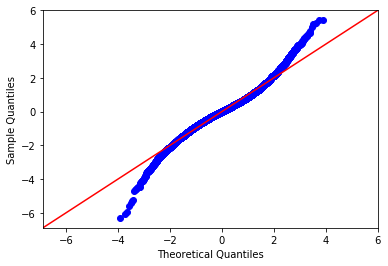

In [186]:
fig = sm.graphics.qqplot(ols_model_3.resid, dist=stats.norm, line='45', fit=True)

In [187]:
### Stepwise Feature Selection

In [188]:
import statsmodels.api as sm

def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [189]:
predictors4 = stepwise_selection(features_df, price_df)

Add  approx_dist                    with p-value 0.0
Add  sqft_living                    with p-value 0.0
Add  zip_98004                      with p-value 1.19255e-193
Add  view_4                         with p-value 1.66199e-185
Add  zip_98168                      with p-value 1.20234e-137
Add  zip_98106                      with p-value 1.14443e-111
Add  zip_98178                      with p-value 5.65686e-107
Add  zip_98144                      with p-value 4.95375e-106
Add  zip_98108                      with p-value 7.08008e-119
Add  zip_98118                      with p-value 6.65883e-122
Add  zip_98122                      with p-value 1.97184e-118
Add  base_Yes                       with p-value 1.01523e-122
Add  zip_98146                      with p-value 2.94167e-113
Add  view_3                         with p-value 1.14755e-84
Add  zip_98053                      with p-value 1.70025e-85
Add  zip_98029                      with p-value 8.22285e-87
Add  zip_98033               

In [190]:
len(predictors4)

76

In [191]:
mult_linreg4 = run_mult_linreg(features_df, price_df, predictors4)

0.787007056571507
0.7917367759653526
0.7969048646003888
0.798988034341547
0.8035944950787048
0.8048342580928749
0.8076330789857566
0.8107413340544614
0.8125607557695445
0.8135897981989058
0.8176132170038968
0.8220337542014281
0.8249159450824739
0.8263615586867493
0.8283067966219646
0.8289613276239134
0.832454451221896
0.8331948635727683
0.8343030284250175
0.8350027477128107
0.8351286688845965
0.8351287821411875
0.8446489465148477
0.8451591096406517
0.8457003927040305
0.8463091784299522
0.8507300663090713
0.8509434626960147
0.851334365236009
0.851422046413451
0.8520486914176792
0.8521235108344326
0.8522140737574289
0.8541369839946809
0.8544773851619567
0.8545199519350273
0.8546775814682411
0.85487061915663
r-squared: [0.85487061915663]
adj r-squared: [0.8543580804510493]


# run_cross_validation(mult_linreg4,features_df,price_df,predictors4,0)

In [192]:
ols_model_4 = run_ols_model(features_df,price_df,predictors4)
ols_model_4.summary()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21953 entries, 1000102 to 9900000190
Data columns (total 90 columns):
price              21953 non-null float64
sqft_living        21953 non-null float64
approx_dist        21953 non-null float64
flo_2plus          21953 non-null uint8
water_1            21953 non-null uint8
view_1             21953 non-null uint8
view_2             21953 non-null uint8
view_3             21953 non-null uint8
view_4             21953 non-null uint8
cond_good          21953 non-null uint8
sold_2015          21953 non-null uint8
renov_recent       21953 non-null uint8
built_0            21953 non-null uint8
built_2000s        21953 non-null uint8
built_2010s        21953 non-null uint8
built_70s          21953 non-null uint8
built_80s          21953 non-null uint8
built_90s          21953 non-null uint8
built_Before70s    21953 non-null uint8
base_Yes           21953 non-null uint8
zip_98001          21953 non-null uint8
zip_98002          21953 non-null 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     1661.
Date:                Fri, 07 Jun 2019   Prob (F-statistic):               0.00
Time:                        19:33:42   Log-Likelihood:                 3819.7
No. Observations:               21953   AIC:                            -7485.
Df Residuals:                   21876   BIC:                            -6870.
Df Model:                          76                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          12.5766      0.015    833.104      0.000      12.547      12.606
approx_dist        -0.1480      0.004    -39.403      0.000      -0.155      -0.141
sqft_living         0.3001      0.002    152.969      0.000       0.296       0.304
zip_98004           0.9575      0.013     74.591      0.000       0.932       0.983
view_4              0.4269      0.014     30.136      0.000       0.399       0.455
zip_98168          -0.1582      0.013    -12.137      0.000      -0.184      -0.133
zip_98178          -0.0933      0.013     -7.058      0.000      -0.119      -0.067
zip_98122           0.2864      0.017     16.913      0.000       0.253       0.320
base_Yes           -0.0781      0.004    -21.946      0.000      -0.085      -0.071
view_3              0.2691      0.009     28.547      0.000       0.251       0.288
zip_98053           0.5700      0.011     51.691      0.000       0.548       0.592
zip_98029           0.5761      0.012     47.319      0.000       0.552       0.600
zip_98033           0.6380      0.011     59.234      0.000       0.617       0.659
zip_98075           0.5798      0.012     49.880      0.000       0.557       0.603
zip_98052           0.5552      0.009     58.987      0.000       0.537       0.574
zip_98074           0.5338      0.010     50.978      0.000       0.513       0.554
zip_98045           0.4269      0.015     28.663      0.000       0.398       0.456
zip_98027           0.5092      0.011     47.029      0.000       0.488       0.530
zip_98126           0.2174      0.013     17.008      0.000       0.192       0.242
zip_98065           0.4087      0.013     32.178      0.000       0.384       0.434
view_2              0.1670      0.007     23.963      0.000       0.153       0.181
zip_98006           0.5717      0.010     56.526      0.000       0.552       0.591
zip_98040           0.7295      0.014     53.400      0.000       0.703       0.756
zip_98077           0.5420      0.015     36.027      0.000       0.513       0.572
zip_98039           1.1498      0.029     39.381      0.000       1.093       1.207
water_1             0.4484      0.021     21.500      0.000       0.408       0.489
zip_98072           0.4700      0.013     36.292      0.000       0.445       0.495
zip_98008           0.5169      0.013     40.239      0.000       0.492       0.542
zip_98188          -0.0666      0.018     -3.746      0.000      -0.101      -0.032
zip_98198          -0.0294      0.013     -2.326      0.020      -0.054      -0.005
zip_98024           0.5074      0.023     22.074      0.000       0.462       0.552
zip_98005           0.6388      0.017     38.623      0.000       0.606       0.671
zip_98117           0.5576      0.010     54.300      0.000       0.537       0.578
zip_98115           0.5518      0.010     54.222      0.000

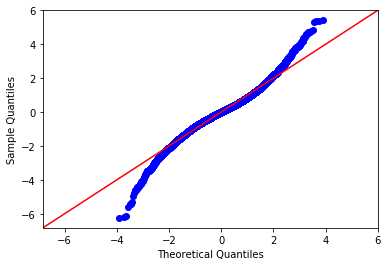

In [193]:
fig = sm.graphics.qqplot(ols_model_4.resid, dist=stats.norm, line='45', fit=True)

In [194]:
run_cross_validation(mult_linreg4,features_df,price_df,predictors4,10)

76 predictors used.
[-0.09451678 -0.03594111 -0.03421179 -0.0348617  -0.03316006 -0.03259479
 -0.03205273 -0.03364112 -0.03723038 -0.13929656]


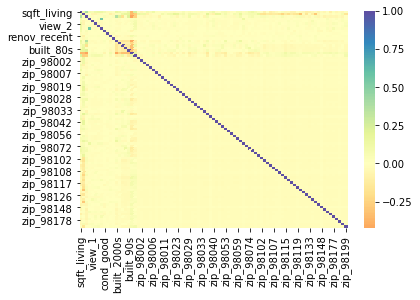

In [195]:
sns.heatmap(features_df.corr(), center=0, cmap='Spectral');

In [196]:
(features_df.corr()>.5).sum().sum()

91

In [197]:
features_df.shape

(21597, 89)

In [ ]:
View and Water are correlated

In [198]:
features_df[predictors4].shape

(21597, 76)

### QC: Train/Test MSE

In [200]:
from sklearn.model_selection import train_test_split
X = features_df[predictors4]
y = price_df
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=3)

linreg = LinearRegression()
MSE_test = []
MSE_train = []
list_n = list(range(6,76,10))
for n in list_n: 
    select_n = RFE(linreg, n_features_to_select = n)
    select_n = select_n.fit(X_train, np.ravel(y_train))
    selected_columns = X.columns[select_n.support_ ]
    linreg.fit(X_train[selected_columns],y_train)
    yhat_train = linreg.predict(X_train[selected_columns])
    yhat_test = linreg.predict(X_test[selected_columns])
    mse_train = np.sum((y_train-yhat_train)**2)/len(y_train)
    mse_test =np.sum((y_test-yhat_test)**2)/len(y_test)
    print(mse_train)
    print(mse_test)
MSE_test.append(mse_test)
MSE_train.append(mse_train)
print(n)


price    0.229316
dtype: float64
price    0.214977
dtype: float64
price    0.190306
dtype: float64
price    0.180733
dtype: float64
price    0.164092
dtype: float64
price    0.153028
dtype: float64
price    0.139894
dtype: float64
price    0.127726
dtype: float64
price    0.052755
dtype: float64
price    0.050147
dtype: float64
price    0.046464
dtype: float64
price    0.044022
dtype: float64
price    0.041527
dtype: float64
price    0.040168
dtype: float64
66


In [218]:
data_df = price_df.join(features_df,how='left')
data_df.corr().sort_values(by='price',ascending=False)

,price,sqft_living,approx_dist,flo_2plus,water_1,view_1,view_2,view_3,view_4,cond_good,...,zip_98146,zip_98148,zip_98155,zip_98166,zip_98168,zip_98177,zip_98178,zip_98188,zip_98198,zip_98199
price,1.000000,0.675281,-0.330152,0.325145,0.169242,0.097488,0.157917,0.173397,0.224284,0.099457,...,-0.090107,-0.052703,-0.045405,-0.029088,-0.154378,0.052004,-0.103893,-0.079549,-0.113514,0.101837
sqft_living,0.675281,1.000000,0.129906,0.397997,0.078748,0.063597,0.123112,0.143011,0.135037,0.096851,...,-0.068712,-0.029501,-0.047301,-0.003904,-0.090438,0.028608,-0.048841,-0.025111,-0.043395,0.011282
flo_2plus,0.325145,0.397997,-0.038765,1.000000,0.021974,-0.021574,0.009762,0.020248,0.021659,0.062424,...,-0.057738,-0.029317,-0.070567,-0.047578,-0.061807,-0.047598,-0.060120,-0.036165,-0.055686,-0.004846
view_4,0.224284,0.135037,-0.028918,0.021659,0.562527,-0.015143,-0.026118,-0.018921,1.000000,0.004653,...,0.034288,-0.006344,0.000851,0.038829,-0.013915,0.071115,0.024122,-0.009719,0.032252,-0.014839
zip_98004,0.222742,0.094690,-0.079958,-0.015461,-0.005298,0.037766,0.007385,-0.008823,0.010329,0.004591,...,-0.014387,-0.006324,-0.017702,-0.013388,-0.013871,-0.013258,-0.013593,-0.009689,-0.014094,-0.014792
base_Yes,0.209696,0.235587,-0.271741,-0.247431,0.037808,0.086881,0.103521,0.096727,0.079094,0.020034,...,-0.008201,-0.019353,0.003494,0.017406,-0.007598,0.043618,0.021330,-0.003671,-0.009500,0.101909
zip_98040,0.185331,0.114316,-0.081123,0.001809,0.045412,0.058784,0.040930,0.057241,0.023017,0.003310,...,-0.013473,-0.005922,-0.016577,-0.012537,-0.012989,-0.012415,-0.012729,-0.009073,-0.013199,-0.013852
view_3,0.173397,0.143011,-0.035322,0.020248,0.039218,-0.019187,-0.033093,1.000000,-0.018921,0.009480,...,0.007575,-0.008038,-0.011917,0.021820,-0.017631,0.013955,0.012787,0.002931,0.029577,0.056719
water_1,0.169242,0.078748,0.000192,0.021974,1.000000,-0.005547,0.001706,0.039218,0.562527,-0.003065,...,0.019205,-0.004248,0.007800,0.063261,-0.009317,-0.003695,0.036633,-0.006508,0.034711,-0.005253
view_2,0.157917,0.123112,-0.066444,0.009762,0.001706,-0.026485,1.000000,-0.033093,-0.026118,0.014727,...,-0.006109,-0.011095,-0.010700,0.031923,-0.020372,0.049257,0.034790,-0.005720,0.014311,0.039231
